In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
from nilmtk import DataSet
from nilmtk.utils import print_dict

redd = DataSet('converted_REDD.h5')

In [10]:
from collections import OrderedDict
import numpy as np
import pandas as pd
from nilmtk.disaggregate import Disaggregator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential


class SequenceLengthError(Exception):
    pass

class ApplianceNotFoundError(Exception):
    pass

class MonteCarloDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class Seq2Seq(Disaggregator):

    def __init__(self, params):

        self.MODEL_NAME = "Seq2Seq"
        self.file_prefix = "{}-temp-weights".format(self.MODEL_NAME.lower())
        self.chunk_wise_training = params.get('chunk_wise_training',False)
        self.sequence_length = params.get('sequence_length',99)
        self.n_epochs = params.get('n_epochs', 10)
        self.models = OrderedDict()
        self.mains_mean = 1800
        self.mains_std = 600
        self.batch_size = params.get('batch_size',512)
        self.appliance_params = params.get('appliance_params',{})
        if self.sequence_length%2==0:
            print ("Sequence length should be odd!")
            raise (SequenceLengthError)

    def partial_fit(self, train_main, train_appliances, do_preprocessing=True, current_epoch=0, **load_kwargs):
        print("...............Seq2Seq partial_fit running...............")
        if len(self.appliance_params) == 0:
            self.set_appliance_params(train_appliances)

        if do_preprocessing:
            train_main, train_appliances = self.call_preprocessing(
                train_main, train_appliances, 'train')

        train_main = pd.concat(train_main, axis=0)
        train_main = train_main.values.reshape((-1, self.sequence_length, 1))
        new_train_appliances = []
        for app_name, app_dfs in train_appliances:
            app_df = pd.concat(app_dfs, axis=0)
            app_df_values = app_df.values.reshape((-1, self.sequence_length))
            new_train_appliances.append((app_name, app_df_values))

        train_appliances = new_train_appliances
        for appliance_name, power in train_appliances:
            if appliance_name not in self.models:
                print("First model training for ", appliance_name)
                self.models[appliance_name] = self.return_network()
            else:
                print("Started Retraining model for ", appliance_name)

            model = self.models[appliance_name]
            if train_main.size > 0:
                # Sometimes chunks can be empty after dropping NANS
                if len(train_main) > 10:
                    # Do validation when you have sufficient samples
                    filepath = self.file_prefix + "-{}-epoch{}.h5".format(
                            "_".join(appliance_name.split()),
                            current_epoch,
                    )
                    checkpoint = ModelCheckpoint(filepath,monitor='val_loss',verbose=1,save_best_only=True,mode='min')
                    model.fit(
                            train_main, power,
                            validation_split=.15,
                            epochs=self.n_epochs,
                            batch_size=self.batch_size,
                            callbacks=[ checkpoint ],
                    )
                    model.load_weights(filepath)

                    
    def disaggregate_chunk(self,test_main_list,model=None,do_preprocessing=True):
        if model is not None:
            self.models = model

        if do_preprocessing:
            test_main_list = self.call_preprocessing(
                test_main_list, submeters_lst=None, method='test')

        test_predictions = []
        for test_mains_df in test_main_list:
        
            disggregation_dict = {}
            test_main_array = test_mains_df.values.reshape((-1, self.sequence_length, 1))
            
            all_preds = []
            for appliance in self.models:
                
                for i in range(100):
                    
                    if i%10==0:
                        print(i)
                        
                    prediction = []
                    model = self.models[appliance]
                    prediction = model.predict(test_main_array ,batch_size=self.batch_size)

                    #####################
                    # This block is for creating the average of predictions over the different sequences
                    # the counts_arr keeps the number of times a particular timestamp has occured
                    # the sum_arr keeps the number of times a particular timestamp has occured
                    # the predictions are summed for  agiven time, and is divided by the number of times it has occured

                    l = self.sequence_length
                    n = len(prediction) + l - 1
                    sum_arr = np.zeros((n))
                    counts_arr = np.zeros((n))
                    o = len(sum_arr)
                    for i in range(len(prediction)):
                        sum_arr[i:i + l] += prediction[i].flatten()
                        counts_arr[i:i + l] += 1
                    for i in range(len(sum_arr)):
                        sum_arr[i] = sum_arr[i] / counts_arr[i]

                    #################
                    prediction = self.appliance_params[appliance]['mean'] + (sum_arr * self.appliance_params[appliance]['std'])
                    valid_predictions = prediction.flatten()
                    valid_predictions = np.where(valid_predictions > 0, valid_predictions, 0)
                    
                    all_preds.append(valid_predictions)
                
                valid_predictions = np.mean(all_preds, axis=0)
                var_predictions = np.std(all_preds, axis=0)
                    
                df = pd.Series(valid_predictions)
                disggregation_dict[appliance] = df
                
            results = pd.DataFrame(disggregation_dict, dtype='float32')
            test_predictions.append(results)
            
            df_mean = pd.DataFrame(valid_predictions)
            df_var = pd.DataFrame(var_predictions)
            
            df_mean.to_csv('mean_Microwave_s2s.csv')
            df_var.to_csv('var_Microwave_s2s.csv')

        return test_predictions

    def return_network(self):

        model = Sequential()
        # 1D Conv
        model.add(Conv1D(30,10,activation="relu",input_shape=(self.sequence_length,1),strides=2))
        model.add(Conv1D(30, 8, activation='relu', strides=2))
        model.add(Conv1D(40, 6, activation='relu', strides=1))
        model.add(Conv1D(50, 5, activation='relu', strides=1))
#         model.add(Dropout(.2))
        model.add(MonteCarloDropout(.2))
        model.add(Conv1D(50, 5, activation='relu', strides=1))
#         model.add(Dropout(.2))
        model.add(MonteCarloDropout(.2))
        model.add(Flatten())
        model.add(Dense(1024, activation='relu'))
#         model.add(Dropout(.2))
        model.add(MonteCarloDropout(.2))
        model.add(Dense(self.sequence_length))
        model.compile(loss='mse', optimizer='adam')

        return model

    def call_preprocessing(self, mains_lst, submeters_lst, method):

        if method == 'train':            
            processed_mains_lst = []
            for mains in mains_lst:
                new_mains = mains.values.flatten()
                n = self.sequence_length
                units_to_pad = n // 2
                new_mains = np.pad(new_mains, (units_to_pad,units_to_pad),'constant',constant_values = (0,0))
                new_mains = np.array([new_mains[i:i + n] for i in range(len(new_mains) - n + 1)])
                new_mains = (new_mains - self.mains_mean) / self.mains_std
                processed_mains_lst.append(pd.DataFrame(new_mains))
            #new_mains = pd.DataFrame(new_mains)
            appliance_list = []
            for app_index, (app_name, app_df_lst) in enumerate(submeters_lst):

                if app_name in self.appliance_params:
                    app_mean = self.appliance_params[app_name]['mean']
                    app_std = self.appliance_params[app_name]['std']
                else:
                    print ("Parameters for ", app_name ," were not found!")
                    raise ApplianceNotFoundError()


                processed_app_dfs = []
                for app_df in app_df_lst:                    
                    new_app_readings = app_df.values.flatten()
                    new_app_readings = np.pad(new_app_readings, (units_to_pad,units_to_pad),'constant',constant_values = (0,0))
                    new_app_readings = np.array([new_app_readings[i:i + n] for i in range(len(new_app_readings) - n + 1)])                    
                    new_app_readings = (new_app_readings - app_mean) / app_std  # /self.max_val
                    processed_app_dfs.append(pd.DataFrame(new_app_readings))
                    
                    
                appliance_list.append((app_name, processed_app_dfs))
                #new_app_readings = np.array([ new_app_readings[i:i+n] for i in range(len(new_app_readings)-n+1) ])
                #print (new_mains.shape, new_app_readings.shape, app_name)

            return processed_mains_lst, appliance_list

        else:
            processed_mains_lst = []
            for mains in mains_lst:
                new_mains = mains.values.flatten()
                n = self.sequence_length
                units_to_pad = n // 2
                #new_mains = np.pad(new_mains, (units_to_pad,units_to_pad),'constant',constant_values = (0,0))
                new_mains = np.array([new_mains[i:i + n] for i in range(len(new_mains) - n + 1)])
                new_mains = (new_mains - self.mains_mean) / self.mains_std
                new_mains = new_mains.reshape((-1, self.sequence_length))
                processed_mains_lst.append(pd.DataFrame(new_mains))
            return processed_mains_lst

    def set_appliance_params(self,train_appliances):

        for (app_name,df_list) in train_appliances:
            l = np.array(pd.concat(df_list,axis=0))
            app_mean = np.mean(l)
            app_std = np.std(l)
            if app_std<1:
                app_std = 100
            self.appliance_params.update({app_name:{'mean':app_mean,'std':app_std}})

In [11]:
from nilmtk.dataset import DataSet
from nilmtk.metergroup import MeterGroup
import pandas as pd
from nilmtk.losses import *
import numpy as np
import matplotlib.pyplot as plt
import datetime
from IPython.display import clear_output


class API():

    """
    The API ia designed for rapid experimentation with NILM Algorithms.
    """

    def __init__(self,params):
        """
        Initialize the API with default parameters and then start the experiment.
        """

        self.appliances = []
        self.train_submeters = []
        self.train_mains = pd.DataFrame()
        self.test_submeters = []
        self.test_mains = pd.DataFrame()
        self.gt_overall = {}
        self.pred_overall = {}
        self.classifiers=[]
        self.errors = []
        self.errors_keys = []
        self.power = params['power']
        for elems in params['appliances']:
            self.appliances.append(elems)

        self.train_datasets_dict = params['train']['datasets']
        self.test_datasets_dict = params['test']['datasets']
        self.metrics = params['test']['metrics']
        self.methods = params['methods']
        self.sample_period = params.get("sample_rate", 1)
        self.artificial_aggregate = params.get('artificial_aggregate', False)
        self.chunk_size = params.get('chunk_size', None)
        self.display_predictions = params.get('display_predictions', False)
        self.DROP_ALL_NANS = params.get("DROP_ALL_NANS", True)
        self.site_only = params.get('site_only',False)
        self.experiment()
        

    def experiment(self):
        """
        Calls the Experiments with the specified parameters
        """

        self.store_classifier_instances()
        d=self.train_datasets_dict

        for model_name, clf in self.classifiers:
            # If the model is a neural net, it has an attribute n_epochs, Ex: DAE, Seq2Point
            print ("Started training for ",clf.MODEL_NAME)

            # If the model has the filename specified for loading the pretrained model, then we don't need to load training data

            if hasattr(clf,'load_model_path'):
                if clf.load_model_path:
                    print (clf.MODEL_NAME," is loading the pretrained model")
                    continue

            # if user wants to train chunk wise
            if self.chunk_size:
                # If the classifier supports chunk wise training
                if clf.chunk_wise_training:
                    # if it has an attribute n_epochs. Ex: neural nets. Then it is trained chunk wise for every wise
                    if hasattr(clf,'n_epochs'):
                        n_epochs = clf.n_epochs
                        clf.n_epochs = 1
                    else:
                        # If it doesn't have the attribute n_epochs, this is executed. Ex: Mean, Zero
                        n_epochs = 1
                    # Training on those many chunks for those many epochs
                    print ("Chunk wise training for ",clf.MODEL_NAME)
                    for i in range(n_epochs):
                        self.train_chunk_wise(clf, d, i)

                else:
                    print ("Joint training for ",clf.MODEL_NAME)
                    self.train_jointly(clf,d)            

            # if it doesn't support chunk wise training
            else:
                print ("Joint training for ",clf.MODEL_NAME)
                self.train_jointly(clf,d)            

            print ("Finished training for ",clf.MODEL_NAME)
            clear_output()

        d=self.test_datasets_dict

        if self.chunk_size:
            print ("Chunk Wise Testing for all algorithms")
            # It means that, predictions can also be done on chunks
            self.test_chunk_wise(d)

        else:
            print ("Joint Testing for all algorithms")
            self.test_jointly(d)

    def train_chunk_wise(self, clf, d, current_epoch):
        """
        This function loads the data from buildings and datasets with the specified chunk size and trains on each of them. 
        """
            
        for dataset in d:
            # Loading the dataset
            print("Loading data for ",dataset, " dataset")          
            for building in d[dataset]['buildings']:
                # Loading the building
                train=DataSet(d[dataset]['path'])
                print("Loading building ... ",building)
                train.set_window(start=d[dataset]['buildings'][building]['start_time'],end=d[dataset]['buildings'][building]['end_time'])
                mains_iterator = train.buildings[building].elec.mains().load(chunksize = self.chunk_size, physical_quantity='power', ac_type = self.power['mains'], sample_period=self.sample_period)
                appliance_iterators = [train.buildings[building].elec[app_name].load(chunksize = self.chunk_size, physical_quantity='power', ac_type=self.power['appliance'], sample_period=self.sample_period) for app_name in self.appliances]
                print(train.buildings[building].elec.mains())
                for chunk_num,chunk in enumerate (train.buildings[building].elec.mains().load(chunksize = self.chunk_size, physical_quantity='power', ac_type = self.power['mains'], sample_period=self.sample_period)):
                    # Loading the chunk for the specifeid building
                    #Dummry loop for executing on outer level. Just for looping till end of a chunk
                    print("Starting enumeration..........")
                    train_df = next(mains_iterator)
                    appliance_readings = []
                    for i in appliance_iterators:
                        try:
                            appliance_df = next(i)
                        except StopIteration:
                            appliance_df = pd.DataFrame()
                        appliance_readings.append(appliance_df)

                    if self.DROP_ALL_NANS:
                        train_df, appliance_readings = self.dropna(train_df, appliance_readings)
                    
                    if self.artificial_aggregate:
                        print ("Creating an Artificial Aggregate")
                        train_df = pd.DataFrame(np.zeros(appliance_readings[0].shape),index = appliance_readings[0].index,columns=appliance_readings[0].columns)
                        for app_reading in appliance_readings:
                            train_df+=app_reading
                    train_appliances = []

                    for cnt,i in enumerate(appliance_readings):
                        train_appliances.append((self.appliances[cnt],[i]))

                    self.train_mains = [train_df]
                    self.train_submeters = train_appliances
                    clf.partial_fit(self.train_mains, self.train_submeters, current_epoch)
                

        print("...............Finished the Training Process ...................")

    def test_chunk_wise(self,d):

        print("...............Started  the Testing Process ...................")

        for dataset in d:
            print("Loading data for ",dataset, " dataset")
            for building in d[dataset]['buildings']:
                test=DataSet(d[dataset]['path'])
                test.set_window(start=d[dataset]['buildings'][building]['start_time'],end=d[dataset]['buildings'][building]['end_time'])
                mains_iterator = test.buildings[building].elec.mains().load(chunksize = self.chunk_size, physical_quantity='power', ac_type = self.power['mains'], sample_period=self.sample_period)
                appliance_iterators = [test.buildings[building].elec[app_name].load(chunksize = self.chunk_size, physical_quantity='power', ac_type=self.power['appliance'], sample_period=self.sample_period) for app_name in self.appliances]
                for chunk_num,chunk in enumerate (test.buildings[building].elec.mains().load(chunksize = self.chunk_size, physical_quantity='power', ac_type = self.power['mains'], sample_period=self.sample_period)):
                    test_df = next(mains_iterator)
                    appliance_readings = []
                    for i in appliance_iterators:
                        try:
                            appliance_df = next(i)
                        except StopIteration:
                            appliance_df = pd.DataFrame()

                        appliance_readings.append(appliance_df)

                    if self.DROP_ALL_NANS:
                        test_df, appliance_readings = self.dropna(test_df, appliance_readings)

                    if self.artificial_aggregate:
                        print ("Creating an Artificial Aggregate")
                        test_df = pd.DataFrame(np.zeros(appliance_readings[0].shape),index = appliance_readings[0].index,columns=appliance_readings[0].columns)
                        for app_reading in appliance_readings:
                            test_df+=app_reading

                    test_appliances = []

                    for cnt,i in enumerate(appliance_readings):
                        test_appliances.append((self.appliances[cnt],[i]))

                    self.test_mains = [test_df]
                    self.test_submeters = test_appliances
                    print("Results for Dataset {dataset} Building {building} Chunk {chunk_num}".format(dataset=dataset,building=building,chunk_num=chunk_num))
                    self.storing_key = str(dataset) + "_" + str(building) + "_" + str(chunk_num) 
                    self.call_predict(self.classifiers, test.metadata['timezone'])


    def train_jointly(self,clf,d):

        # This function has a few issues, which should be addressed soon
        print("............... Loading Data for training ...................")
        # store the train_main readings for all buildings
        self.train_mains = []
        self.train_submeters = [[] for i in range(len(self.appliances))]
        for dataset in d:
            print("Loading data for ",dataset, " dataset")
            train=DataSet(d[dataset]['path'])
            for building in d[dataset]['buildings']:
                print("Loading building ... ",building)
                train.set_window(start=d[dataset]['buildings'][building]['start_time'],end=d[dataset]['buildings'][building]['end_time'])
                train_df = next(train.buildings[building].elec.mains().load(physical_quantity='power', ac_type=self.power['mains'], sample_period=self.sample_period))
                train_df = train_df[[list(train_df.columns)[0]]]
                appliance_readings = []
                
                for appliance_name in self.appliances:
                    appliance_df = next(train.buildings[building].elec[appliance_name].load(physical_quantity='power', ac_type=self.power['appliance'], sample_period=self.sample_period))
                    appliance_df = appliance_df[[list(appliance_df.columns)[0]]]
                    appliance_readings.append(appliance_df)

                if self.DROP_ALL_NANS:
                    train_df, appliance_readings = self.dropna(train_df, appliance_readings)

                if self.artificial_aggregate:
                    print ("Creating an Artificial Aggregate")
                    train_df = pd.DataFrame(np.zeros(appliance_readings[0].shape),index = appliance_readings[0].index,columns=appliance_readings[0].columns)
                    for app_reading in appliance_readings:
                        train_df+=app_reading

                self.train_mains.append(train_df)
                for i,appliance_name in enumerate(self.appliances):
                    self.train_submeters[i].append(appliance_readings[i])

        appliance_readings = []
        for i,appliance_name in enumerate(self.appliances):
            appliance_readings.append((appliance_name, self.train_submeters[i]))

        self.train_submeters = appliance_readings   

        clf.partial_fit(self.train_mains,self.train_submeters)

    
    def test_jointly(self,d):
        # store the test_main readings for all buildings
        for dataset in d:
            print("Loading data for ",dataset, " dataset")
            test=DataSet(d[dataset]['path'])
            for building in d[dataset]['buildings']:
                test.set_window(start=d[dataset]['buildings'][building]['start_time'],end=d[dataset]['buildings'][building]['end_time'])
                test_mains=next(test.buildings[building].elec.mains().load(physical_quantity='power', ac_type=self.power['mains'], sample_period=self.sample_period))
                if self.DROP_ALL_NANS and self.site_only:
                    test_mains, _= self.dropna(test_mains,[])

                if self.site_only != True:
                    appliance_readings=[]

                    for appliance in self.appliances:
                        test_df=next((test.buildings[building].elec[appliance].load(physical_quantity='power', ac_type=self.power['appliance'], sample_period=self.sample_period)))
                        appliance_readings.append(test_df)
                    
                    if self.DROP_ALL_NANS:
                        test_mains , appliance_readings = self.dropna(test_mains,appliance_readings)
                
                    if self.artificial_aggregate:
                        print ("Creating an Artificial Aggregate")
                        test_mains = pd.DataFrame(np.zeros(appliance_readings[0].shape),index = appliance_readings[0].index,columns=appliance_readings[0].columns)
                        for app_reading in appliance_readings:
                            test_mains+=app_reading
                    for i, appliance_name in enumerate(self.appliances):
                        self.test_submeters.append((appliance_name,[appliance_readings[i]]))

                self.test_mains = [test_mains]
                self.storing_key = str(dataset) + "_" + str(building) 
                self.call_predict(self.classifiers, test.metadata["timezone"])


    def dropna(self,mains_df, appliance_dfs=[]):
        """
        Drops the missing values in the Mains reading and appliance readings and returns consistent data by copmuting the intersection
        """
        print ("Dropping missing values")

        # The below steps are for making sure that data is consistent by doing intersection across appliances
        mains_df = mains_df.dropna()
        ix = mains_df.index
        mains_df = mains_df.loc[ix]
        for i in range(len(appliance_dfs)):
            appliance_dfs[i] = appliance_dfs[i].dropna()
    
        for  app_df in appliance_dfs:
            ix = ix.intersection(app_df.index)
        mains_df = mains_df.loc[ix]
        new_appliances_list = []
        for app_df in appliance_dfs:
            new_appliances_list.append(app_df.loc[ix])
        return mains_df,new_appliances_list
    
    
    def store_classifier_instances(self):

        """
        This function is reponsible for initializing the models with the specified model parameters
        """
        for name in self.methods:
            try:
                                
                clf=self.methods[name]
                self.classifiers.append((name,clf))

            except Exception as e:
                print ("\n\nThe method {model_name} specied does not exist. \n\n".format(model_name=name))
                print (e)
    
    def call_predict(self, classifiers, timezone):

        """
        This functions computers the predictions on the self.test_mains using all the trained models and then compares different learn't models using the metrics specified
        """
        
        pred_overall={}
        gt_overall={}           
        for name,clf in classifiers:
            gt_overall,pred_overall[name]=self.predict(clf,self.test_mains,self.test_submeters, self.sample_period, timezone)

        self.gt_overall=gt_overall
        self.pred_overall=pred_overall
        if self.site_only != True:
            if gt_overall.size==0:
                print ("No samples found in ground truth")
                return None
            for metric in self.metrics:
                try:
                    loss_function = globals()[metric]                
                except:
                    print ("Loss function ",metric, " is not supported currently!")
                    continue

                computed_metric={}
                for clf_name,clf in classifiers:
                    computed_metric[clf_name] = self.compute_loss(gt_overall, pred_overall[clf_name], loss_function)
                computed_metric = pd.DataFrame(computed_metric)
                print("............ " ,metric," ..............")
                print(computed_metric) 
                self.errors.append(computed_metric)
                self.errors_keys.append(self.storing_key + "_" + metric)


        if self.site_only != True:
            for i in gt_overall.columns:
                plt.figure()
                #plt.plot(self.test_mains[0],label='Mains reading')
                plt.plot(gt_overall[i],label='Truth')
                for clf in pred_overall:                
                    plt.plot(pred_overall[clf][i],label='Predicted')
                    plt.xticks(rotation=90)
                plt.title(i)
                plt.legend(loc = 'upper right')
                plt.xlabel('Time')
                plt.ylabel('Power (W)')
            plt.ylim(0, 1600)
            plt.savefig('plt_Microwave_s2s.pdf', bbox_inches = 'tight')
            plt.show()
            plt.close()
        
    def predict(self, clf, test_elec, test_submeters, sample_period, timezone ):
        print ("Generating predictions for :",clf.MODEL_NAME)        
        """
        Generates predictions on the test dataset using the specified classifier.
        """
        
        # "ac_type" varies according to the dataset used. 
        # Make sure to use the correct ac_type before using the default parameters in this code.   
        
           
        pred_list = clf.disaggregate_chunk(test_elec)

        # It might not have time stamps sometimes due to neural nets
        # It has the readings for all the appliances

        concat_pred_df = pd.concat(pred_list,axis=0)

        gt = {}
        for meter,data in test_submeters:
                concatenated_df_app = pd.concat(data,axis=1)
                index = concatenated_df_app.index
                gt[meter] = pd.Series(concatenated_df_app.values.flatten(),index=index)

        gt_overall = pd.DataFrame(gt, dtype='float32')
        pred = {}

        if self.site_only ==True:
            for app_name in concat_pred_df.columns:
                app_series_values = concat_pred_df[app_name].values.flatten()
                pred[app_name] = pd.Series(app_series_values)
            pred_overall = pd.DataFrame(pred,dtype='float32')
            pred_overall.plot(label="Pred")
            plt.title('Disaggregated Data')
            plt.legend()

        else:
            for app_name in concat_pred_df.columns:
                app_series_values = concat_pred_df[app_name].values.flatten()
                # Neural nets do extra padding sometimes, to fit, so get rid of extra predictions
                app_series_values = app_series_values[:len(gt_overall[app_name])]
                pred[app_name] = pd.Series(app_series_values, index = gt_overall.index)
            pred_overall = pd.DataFrame(pred,dtype='float32')
        gt_df = pd.DataFrame(gt_overall)
        pred_df = pd.DataFrame(pred_overall)
#         print(gt_df)
#         print(pred_df)
        gt_df.to_csv('gt_Microwave_s2s.csv')
        pred_df.to_csv('pred_Microwave_s2s.csv')
        return gt_overall, pred_overall


    # metrics
    def compute_loss(self,gt,clf_pred, loss_function):
        error = {}
        for app_name in gt.columns:
            error[app_name] = loss_function(gt[app_name],clf_pred[app_name])
        return pd.Series(error)

Joint Testing for all algorithms
Loading data for  REDD  dataset
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Dropping missing values
Generating predictions for : Seq2Seq
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
............  rmse  ..............
               Seq2Seq
dish washer  52.667613


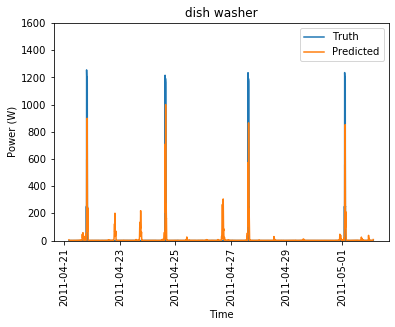

In [12]:
import warnings
warnings.filterwarnings("ignore")

from nilmtk.disaggregate import Mean
from nilmtk_contrib.disaggregate import DAE, RNN, WindowGRU


experiment = {
  'power': {'mains': ['apparent','active'],'appliance': ['apparent','active']},
  'sample_rate': 60,
  'appliances': ['microwave'],
  'methods': {'Seq2Seq':Seq2Seq({'n_epochs':50,'batch_size':32})},
  'train': {    
    'datasets': {
        'REDD': {
            'path': 'converted_REDD.h5',
            'buildings': {
                1: {
                    'start_time': '2011-04-21',
                    'end_time': '2011-05-21'
                    },
                2: {
                    'start_time': '2011-04-21',
                    'end_time': '2011-05-21'
                    }
                }                
            }
        }
    },
  'test': {
    'datasets': {
        'REDD': {
            'path': 'converted_REDD.h5',
            'buildings': {
                3: {
                    'start_time': '2011-04-21',
                    'end_time': '2011-05-21'
                    }
                }
            }
        },
        'metrics':['rmse']
    }
}

api_res = API(experiment)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_gt = pd.read_csv('gt_Microwave_s2s.csv')
df_pred = pd.read_csv('pred_Microwave_s2s.csv')
df_var = pd.read_csv('var_Microwave_s2s.csv')

date = []
for i in range(len(df_gt)):
    date.append(df_gt['Unnamed: 0'][i][:10])
plt.figure(figsize=(13,9))
plt.plot(date, df_gt['microwave'], label = 'Truth')
plt.plot(date, df_pred['microwave'], label = 'Predicted')
plt.fill_between( date,
        df_pred['microwave'] - df_var['0'] * ((3+1.)),
        df_pred['microwave'] + df_var['0'] * ((3+1.)),
        color="g",
        alpha=0.4)
plt.title("Microwave")
plt.ylabel("Power (W)")
plt.xlabel("Dates")
plt.xticks(rotation=90)
plt.ylim(0, 1600)
plt.legend(loc = 'best')
plt.savefig('plt_Microwave_s2s.pdf', bbox_inches = 'tight')
plt.show()